In [2]:
pip install corpus

In [3]:
pip install wordcloud


In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,precision_score,recall_score

In [6]:
# Importing the training dataset
data_train = pd.read_csv('C:/Users/acer/Desktop/Train_data.csv')
data_train.head()

,text,target
0,@killingbacteria but there so hot right now!,0
1,Cleaning the house. Going to Trafalgar today t...,1
2,"@mrichman It depends on the job, really. Too m...",1
3,"@TwittinLife2you I will enjoy, for sure!",1
4,I am so scared for tomorrow. I'm afraid of sur...,0


In [7]:
data_train.shape

(105000, 2)

In [33]:
# Importing the testing dataset
data_test = pd.read_csv('C:/Users/acer/Desktop/Test_data.csv')
data_test.head()

,text
0,and the phone is dead. i can't rech you
1,no air and its likke 80 outside and im soooo...
2,Good morning! 9:06am here in London. Trying to...
3,Ok @myeditionofgab !
4,hey guys.. how's it goin? i missed updating h...


In [9]:
data_test.shape

(45000, 1)

In [10]:
fig = px.histogram(data_train, x="target")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Score')
fig.show()

It gives the count of targets 0 and 1 respectively.0 is negative sentiment and 1 is positive sentiment.

# Text Pre-processing 


### 1) Removing '@names'

In [11]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [12]:
# We are keeping cleaned text in a new column called 'tidy_text'
data_train['tidy_text'] = np.vectorize(remove_pattern)(data_train['text'], "@[\w]*")
data_train.head(10)

,text,target,tidy_text
0,@killingbacteria but there so hot right now!,0,but there so hot right now!
1,Cleaning the house. Going to Trafalgar today t...,1,Cleaning the house. Going to Trafalgar today t...
2,"@mrichman It depends on the job, really. Too m...",1,"It depends on the job, really. Too much to an..."
3,"@TwittinLife2you I will enjoy, for sure!",1,"I will enjoy, for sure!"
4,I am so scared for tomorrow. I'm afraid of sur...,0,I am so scared for tomorrow. I'm afraid of sur...
5,hand sanitizer reminds me of cheyenne &amp; HS...,0,hand sanitizer reminds me of cheyenne &amp; HS...
6,looking forward to going back to work tomorrow,0,looking forward to going back to work tomorrow
7,twitter and facebook have failed me this morning,0,twitter and facebook have failed me this morning
8,No More Maths my last maths test today yay !,1,No More Maths my last maths test today yay !
9,raiishhxclusive: zit? Ugh. I hate it. Kinda em...,1,raiishhxclusive: zit? Ugh. I hate it. Kinda em...


### 2) Removing links (http | https)

In [13]:
cleaned_text = []

for index, row in data_train.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_text.split() if 'http' not in word]
    cleaned_text.append(' '.join(words_without_links))

data_train['tidy_text'] = cleaned_text
data_train.head(10)

,text,target,tidy_text
0,@killingbacteria but there so hot right now!,0,but there so hot right now!
1,Cleaning the house. Going to Trafalgar today t...,1,Cleaning the house. Going to Trafalgar today t...
2,"@mrichman It depends on the job, really. Too m...",1,"It depends on the job, really. Too much to ans..."
3,"@TwittinLife2you I will enjoy, for sure!",1,"I will enjoy, for sure!"
4,I am so scared for tomorrow. I'm afraid of sur...,0,I am so scared for tomorrow. I'm afraid of sur...
5,hand sanitizer reminds me of cheyenne &amp; HS...,0,hand sanitizer reminds me of cheyenne &amp; HS...
6,looking forward to going back to work tomorrow,0,looking forward to going back to work tomorrow
7,twitter and facebook have failed me this morning,0,twitter and facebook have failed me this morning
8,No More Maths my last maths test today yay !,1,No More Maths my last maths test today yay !
9,raiishhxclusive: zit? Ugh. I hate it. Kinda em...,1,raiishhxclusive: zit? Ugh. I hate it. Kinda em...


### 3) Removing text with empty text


In [14]:
data_train = data_train[data_train['tidy_text']!='']
data_train.head()

,text,target,tidy_text
0,@killingbacteria but there so hot right now!,0,but there so hot right now!
1,Cleaning the house. Going to Trafalgar today t...,1,Cleaning the house. Going to Trafalgar today t...
2,"@mrichman It depends on the job, really. Too m...",1,"It depends on the job, really. Too much to ans..."
3,"@TwittinLife2you I will enjoy, for sure!",1,"I will enjoy, for sure!"
4,I am so scared for tomorrow. I'm afraid of sur...,0,I am so scared for tomorrow. I'm afraid of sur...


### 4) Dropping duplicate rows

In [15]:
data_train.drop_duplicates(subset=['tidy_text'], keep=False)
data_train.head()

,text,target,tidy_text
0,@killingbacteria but there so hot right now!,0,but there so hot right now!
1,Cleaning the house. Going to Trafalgar today t...,1,Cleaning the house. Going to Trafalgar today t...
2,"@mrichman It depends on the job, really. Too m...",1,"It depends on the job, really. Too much to ans..."
3,"@TwittinLife2you I will enjoy, for sure!",1,"I will enjoy, for sure!"
4,I am so scared for tomorrow. I'm afraid of sur...,0,I am so scared for tomorrow. I'm afraid of sur...


### 5) Resetting index
It seems that our index needs to be reset, since after removal of some rows, some index values are missing, which may cause problem in future operations.

In [16]:
data_train = data_train.reset_index(drop=True)
data_train.head()

,text,target,tidy_text
0,@killingbacteria but there so hot right now!,0,but there so hot right now!
1,Cleaning the house. Going to Trafalgar today t...,1,Cleaning the house. Going to Trafalgar today t...
2,"@mrichman It depends on the job, really. Too m...",1,"It depends on the job, really. Too much to ans..."
3,"@TwittinLife2you I will enjoy, for sure!",1,"I will enjoy, for sure!"
4,I am so scared for tomorrow. I'm afraid of sur...,0,I am so scared for tomorrow. I'm afraid of sur...


### 6) Removing Punctuations, Numbers and Special characters
So here we will create one additional column 'absolute_tidy_text' which will contain absolute tidy words which can be further used for sentiment analysis on key words

In [17]:
data_train['absolute_tidy_text'] = data_train['tidy_text'].str.replace("[^a-zA-Z# ]", "")

### 7) Removing Stop words

In [18]:
stopwords_set = stopwords.words('english')
cleaned_text = []

for index, row in data_train.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_text.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating texts list of tuples containing stopwords(list) and sentimentType 
    cleaned_text.append(' '.join(words_without_stopwords))
    
data_train['absolute_tidy_text'] = cleaned_text
data_train.head(10)

,text,target,tidy_text,absolute_tidy_text
0,@killingbacteria but there so hot right now!,0,but there so hot right now!,hot right
1,Cleaning the house. Going to Trafalgar today t...,1,Cleaning the house. Going to Trafalgar today t...,Cleaning house Going Trafalgar today look hors...
2,"@mrichman It depends on the job, really. Too m...",1,"It depends on the job, really. Too much to ans...",It depends job really Too much answer characters
3,"@TwittinLife2you I will enjoy, for sure!",1,"I will enjoy, for sure!",I enjoy sure
4,I am so scared for tomorrow. I'm afraid of sur...,0,I am so scared for tomorrow. I'm afraid of sur...,I scared tomorrow Im afraid surgeriesss
5,hand sanitizer reminds me of cheyenne &amp; HS...,0,hand sanitizer reminds me of cheyenne &amp; HS...,hand sanitizer reminds cheyenne amp HS amp sap...
6,looking forward to going back to work tomorrow,0,looking forward to going back to work tomorrow,looking forward going back work tomorrow
7,twitter and facebook have failed me this morning,0,twitter and facebook have failed me this morning,twitter facebook failed morning
8,No More Maths my last maths test today yay !,1,No More Maths my last maths test today yay !,No More Maths last maths test today yay
9,raiishhxclusive: zit? Ugh. I hate it. Kinda em...,1,raiishhxclusive: zit? Ugh. I hate it. Kinda em...,raiishhxclusive zit Ugh I hate Kinda embarasse...


### 8) Tokenize 'absolute_tidy_text'

In [19]:
tokenized_text = data_train['absolute_tidy_text'].apply(lambda x: x.split())
tokenized_text.head()

0                                         [hot, right]
1    [Cleaning, house, Going, Trafalgar, today, loo...
2    [It, depends, job, really, Too, much, answer, ...
3                                     [I, enjoy, sure]
4       [I, scared, tomorrow, Im, afraid, surgeriesss]
Name: absolute_tidy_text, dtype: object

### 9) Converting words to Lemma

In [20]:
nltk.download('wordnet')
word_lemmatizer = WordNetLemmatizer()

tokenized_text = tokenized_text.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_text.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                         [hot, right]
1    [Cleaning, house, Going, Trafalgar, today, loo...
2    [It, depends, job, really, Too, much, answer, ...
3                                     [I, enjoy, sure]
4           [I, scared, tomorrow, Im, afraid, surgery]
Name: absolute_tidy_text, dtype: object

### 10) Joining all tokens into sentences


In [21]:
for i, tokens in enumerate(tokenized_text):
    tokenized_text[i] = ' '.join(tokens)

data_train['absolute_tidy_text'] = tokenized_text
data_train.head(10)

,text,target,tidy_text,absolute_tidy_text
0,@killingbacteria but there so hot right now!,0,but there so hot right now!,hot right
1,Cleaning the house. Going to Trafalgar today t...,1,Cleaning the house. Going to Trafalgar today t...,Cleaning house Going Trafalgar today look hors...
2,"@mrichman It depends on the job, really. Too m...",1,"It depends on the job, really. Too much to ans...",It depends job really Too much answer character
3,"@TwittinLife2you I will enjoy, for sure!",1,"I will enjoy, for sure!",I enjoy sure
4,I am so scared for tomorrow. I'm afraid of sur...,0,I am so scared for tomorrow. I'm afraid of sur...,I scared tomorrow Im afraid surgery
5,hand sanitizer reminds me of cheyenne &amp; HS...,0,hand sanitizer reminds me of cheyenne &amp; HS...,hand sanitizer reminds cheyenne amp HS amp sap...
6,looking forward to going back to work tomorrow,0,looking forward to going back to work tomorrow,looking forward going back work tomorrow
7,twitter and facebook have failed me this morning,0,twitter and facebook have failed me this morning,twitter facebook failed morning
8,No More Maths my last maths test today yay !,1,No More Maths my last maths test today yay !,No More Maths last math test today yay
9,raiishhxclusive: zit? Ugh. I hate it. Kinda em...,1,raiishhxclusive: zit? Ugh. I hate it. Kinda em...,raiishhxclusive zit Ugh I hate Kinda embarasse...


It gives the count of targets 0 and 1 respectively.data_train.shape

# Visualization

In [22]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

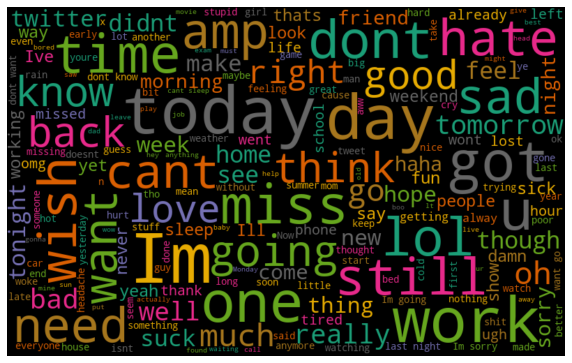

In [23]:
all_words = ' '.join([text for text in data_train['absolute_tidy_text'][data_train['target'] == 0]])
generate_wordcloud(all_words)


Wordcloud showing the frequency of negative sentiments.(Bigger the font of word more is the frequency)

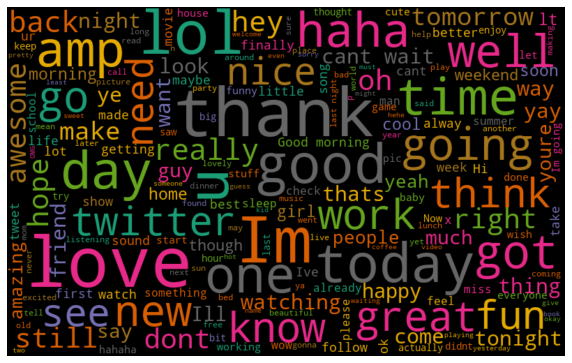

In [24]:
all_words = ' '.join([text for text in data_train['absolute_tidy_text'][data_train['target'] == 1]])
generate_wordcloud(all_words)

Wordcloud showing the frequency of positive sentiments.(Bigger the font of word more is the frequency)

## Creating TF-IDF 

In [25]:
data_train2 = data_train[data_train['absolute_tidy_text'].str.len()>0]
data_train2.shape

(104558, 4)

For sake of consistency, we are going to discard the records which contains no phrases.

In [26]:
# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
X= tfidf_word_vectorizer.fit_transform(data_train2['absolute_tidy_text'])
X.shape

(104558, 20683)

In [27]:
y=data_train2['target']

## Splitting the data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model building

#### 1) MultinomialNB

In [29]:
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB().fit(X_train,y_train)
y_pred=model.predict(X_test)

In [30]:
print(accuracy_score(y_pred,y_test))

0.746987375669472


In [31]:
#Checking Accuracy, Precision, Recall, F1 Score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
results=  pd.DataFrame([['MultinomialNB', acc,prec,rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results

,Model,Accuracy,Precision,Recall,F1 Score
0,MultinomialNB,0.746987,0.75578,0.733853,0.744655


In [35]:
test_pred = model.predict(data_test)

ValueError: could not convert string to float: "and the phone is dead. i can't rech you "

#### 2) Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression